In [1]:
from bitalg.visualizer.main import Visualizer
import numpy as np
from enum import Enum

# 1. Przygotowanie zbiorów punktów

<h2>Funkcje do generacji zbiorów punktów</h2>

In [2]:
# Generate <amount> random points inside a square [corner1;corner2] x [corner1;corner2]
def randSquare(amount, corner1, corner2):
    print(np.random.uniform(corner1, corner2, (amount, 2)))
    return np.random.uniform(corner1, corner2, (amount, 2))

# Generate <amount> random points on a circle of <center> center and <radius> radius
def randCircle(amount, center, radius):
    angleArray = np.random.uniform(0, 2*np.pi, amount)
    return [(radius * np.cos(angle) + center[0], radius * np.sin(angle) + center[1]) for angle in angleArray]

# Generate <amount> random points on a line extending the (point1, point2) vector,
# that fit inside a square [minCoord;maxCoord] x [minCoord;maxCoord]
def randLine(amount, point1, point2, minCoord, maxCoord):
    # 1. x = c (x1 == x2)
    if point1[0] == point2[0]:
        return [(point1[0], y) for y in np.random.uniform(minCoord, maxCoord, amount)]

    # 2. y = b (y1 == y2)
    if point1[1] == point2[1]:
        return [(x, point1[1]) for x in np.random.uniform(minCoord, maxCoord, amount)]
    
    # 3. y = ax + b (x1 != x2 && y1 != y2)
    a = (point1[1]-point2[1]) / (point1[0]-point2[0])
    b = a * (-point1[0]) + point1[1]
    xWhenBoundingY = ((minCoord - b) / a, (maxCoord - b) / a) # x when y in {minCoord, maxCoord}
    minX = max(minCoord, min(xWhenBoundingY))
    maxX = min(maxCoord, max(xWhenBoundingY))
    return [(x, a*x + b) for x in np.random.uniform(minX, maxX, amount)]

<h2>Wygenerowanie zbiorów punktów</h2>

a) 10<sup>5</sup> punktów o współrzędnych z przedziału [-1000; 1000]

In [3]:
pointsA = randSquare(int(1e5), -1000, 1000)

[[-451.78218575  638.25070801]
 [ 329.38445613  771.95831064]
 [ 934.56913687  123.93276542]
 ...
 [-891.06426851  233.82899907]
 [ 961.02367219  748.8362501 ]
 [-714.67856674  -70.18984231]]


b) 10<sup>5</sup> punktów o współrzędnych z przedziału [-10<sup>14</sup>; 10<sup>14</sup>]

In [4]:
pointsB = randSquare(int(1e5), -1e14, 1e14)

[[-6.56736196e+13 -7.84037177e+12]
 [-8.24154352e+13  3.96796297e+12]
 [-5.11924632e+13  1.65878957e+13]
 ...
 [-1.61526420e+13 -2.45932474e+13]
 [-4.87782193e+13 -6.74193051e+13]
 [ 3.60119831e+13 -5.06778535e+13]]


c) 1000 punktów na okręgu x<sup>2</sup> + y<sup>2</sup> = 100<sup>2</sup>

In [5]:
pointsC = randCircle(1000, (0,0), 100)

d) 1000 punktów o współrzędnych z przedziału [-1000; 1000] leżącej na prostej wyznaczonej przez wektor (a, b)
</br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a = (-1.0, 0.0), b = (1.0, 0.1)

In [6]:
pointsD = randLine(1000, (-1.0, 0.0), (1.0, 0.1), -1000, 1000)

# 2. Wizualizacja utworzonych zbiorów punktów

<h2>Funkcja rysowania punktów</h2>

In [7]:
def drawPoints(points):
    canvas = Visualizer()
    canvas.add_point(points)
    canvas.show()

<h2>Rysowanie zbiorów</h2>

a) 10<sup>5</sup> punktów o współrzędnych z przedziału [-1000; 1000]

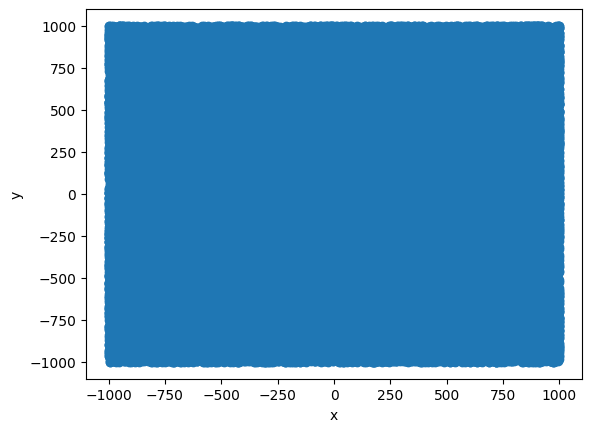

In [8]:
drawPoints(pointsA)

b) 10<sup>5</sup> punktów o współrzędnych z przedziału [-10<sup>14</sup>; 10<sup>14</sup>]

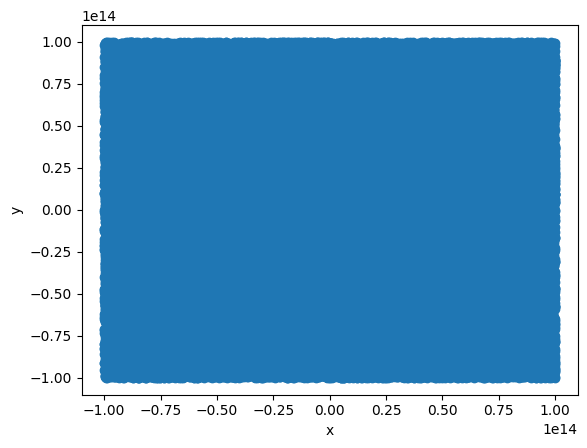

In [9]:
drawPoints(pointsB)

c) 1000 punktów na okręgu x<sup>2</sup> + y<sup>2</sup> = 100<sup>2</sup>

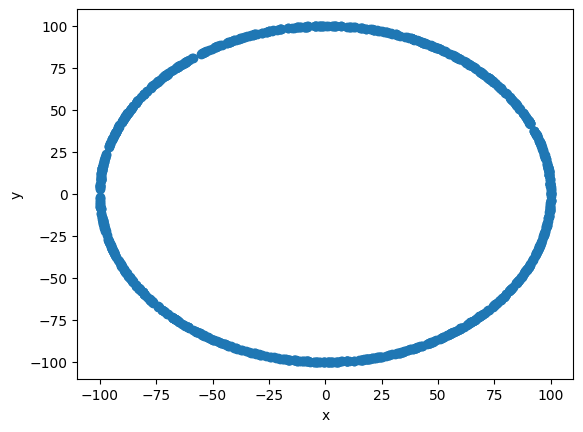

In [10]:
drawPoints(pointsC)

d) 1000 punktów o współrzędnych z przedziału [-1000; 1000] leżącej na prostej wyznaczonej przez wektor (a, b)
</br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a = (-1.0, 0.0), b = (1.0, 0.1)

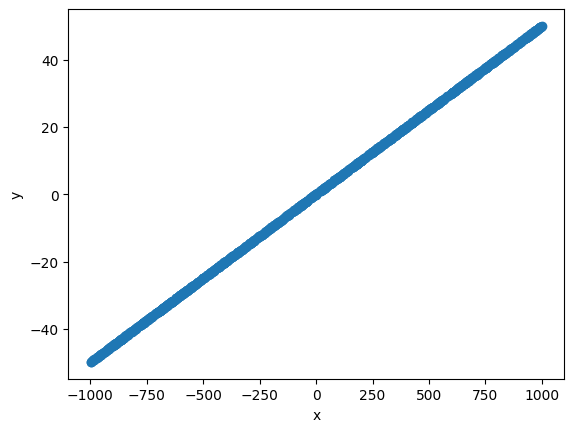

In [11]:
drawPoints(pointsD)

# 3. Podział punktów w zbiorze w zależności od położenia względem prostej

Przyjęta prosta jest wyznaczona przez wektor (a, b), gdzie a = (-1.0, 0.0) i b = (1.0, 0.1)

<h2>Funkcje do obliczania wyznaczników</h2>

In [12]:
# Determinant functions
def myDet3(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + c[0] * a[1] - b[1] * c[0] - c[1] * a[0] - a[1] * b[0]

def myDet2(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

def libDet3(a, b, c):
    matrix = [
        [a[0], a[1], 1],
        [b[0], b[1], 1],
        [c[0], c[1], 1]
    ]
    return np.linalg.det(matrix)

def libDet2(a, b, c):
    matrix = [
        [a[0] - c[0], a[1] - c[1]],
        [b[0] - c[0], b[1] - c[1]]
    ]
    return np.linalg.det(matrix)

<h2>Funkcja dzieląca zbiór punktów na 3 podzbiory o różnych położeniach względem prostej</h2>

In [13]:
# Splits points into pointsAbove, pointsBelow, pointsOn
def splitPoints(points, a, b, detFunction, epsilon):
    above = []
    below = []
    on = []
    for point in points:
        det = detFunction(a, b, point)
        if det > epsilon:
            above.append(point)
        elif det < epsilon:
            below.append(point)
        else:
            on.append(point)
    return above, below, on

<h2>Funkcje do wizualnego przedstawienia punktów względem prostej</h2>

In [14]:
# Draws a set of points in a given color
def drawPointsSet(canvas, points, color="blue"):
    canvas.add_point(points, color=color)

# Draws family of sets of points in different colors
def drawPointsFamily(canvas, pointsFamily, colors):
    for i in len(pointsFamily):
        pointsSet = pointsFamily[i]
        if i < len(colors):
            drawPoints(canvas, pointsSet, colors[i])
        else:
            drawPoints(canvas, pointsSet)

# Draws a line
def drawLine(canvas, point1, point2, color="red"):
    canvas.add_line(point1, point2, color=color)

# Draws and shows points depending on their position relative to a line
def drawEverything(pointsFamily, pointsColors, linePoint1, linePoint2, lineColor):
    canvas = Visualizer()
    drawPointsFamily(canvas, pointsFamily, pointsColors)
    drawLine(canvas, linePoint1, linePoints2, lineColor)
    canvas.show()

<h2>Inicjacja wartości, na których będziemy pracować</h2>

Ustawiamy wartości punktów wyznaczających prostą, kolor tej prostej oraz kolory podzbiorów punktów

In [15]:
linePoint1 = (-1.0,0.0)
linePoint2 = (1.0,0.1)
lineColor = "red"
pointsColors = ["green", "orange", "purple"] # in order: above, below and on the line

Ustalone kolory to:</br>
- kolor prostej - czerwony</br>
- kolor punktów nad prostą (po lewej od prostej) - zielony
- kolor punktów pod prostą (po prawej od prostej) - pomarańczowy
- kolor punktów na prostej - fioletowy

Ustalmy również tablicę epsilonów oraz tablicę funkcji liczenia wyznacznika

In [16]:
epsilons = [0, 1e-14, 1e-12, 1e-10, 1e-8]
detFunctions = [myDet3, myDet2, libDet3, libDet2]

Na koniec utwórzmy tablice dla każdego zbioru punktów, w których będziemy przechowywać informacje na temat ile punktów znalazło się w każdym z podzbiorów w zależności od użytego epsilonu oraz funkcji liczenia wyznacznika

In [22]:
class PointsSet(Enum):
    A = 0
    B = 1
    C = 2
    D = 3

class Precision(Enum):
    FLOAT64 = 0
    FLOAT32 = 1

class Epsilon(Enum):
    ZERO = 0
    E14 = 1
    E12 = 2
    E10 = 3
    E8 = 4

class DetFunction(Enum):
    MY3 = 0
    MY2 = 1
    LIB3 = 2
    LIB2 = 3

class Result:
    def __init__(self):
        self.data = [[[[None for _ in range(4)] for _ in range(5)] for _ in range(2)] for _ in range(4)]
    
    def getData(self, pointsSet, precision, epsilon, detFunction):
        return self.data[pointsSet.value][precision.value][epsilon.value][detFunction.value]

    def setData(self, pointsSet, precision, epsilon, detFunction, data):
        self.data[pointsSet.value][precision.value][epsilon.value][detFunction.value] = data

results = Result()

Implementacja za pomocą enumów pomoże w czytelności kodu podczas przypisywania i pobierania danych

<h2></h2>